# Introduction of this notebook structure:

1. install libraries
2. train the model
3. prediction
4. conclusion

# Day 2: Parking Strategy Recommender (MLP Classifier)

This notebook trains a neural network (MLP) that recommends a parking strategy — either:
- Reverse Parallel
- Forward Perpendicular
- Cannot Park

The model takes 5 features as input:
- Car length
- Car width
- Parking spot length
- Parking spot width
- Distance to parking spot

✅ Summary

🧠 英文总结：
	•	MLP 只决定大方向（倒车、前进、无法停车）
	•	真正的“怎么停”是由轨迹 + 控制模块完成的
	•	所以你已经设计得对了：简单的策略 → 具体路径 → 控制指令

⸻

🧠 中文总结：
	•	MLP 模型只负责做出一个高层策略决定：是否可以停车、采用哪种基本方式（前向、倒车）
	•	实际的转弯角度和前进距离由后续的轨迹生成和控制器模块完成
	•	这种模块化设计能让系统更可控、可解释、可扩展

# 	1.	🔧 !pip install torch joblib

 🚀 STEP 1: Install Required Libraries
- PyTorch is a machine learning framework for building and training neural networks
- joblib is used to save and load Python objects like scalers or models


✅ You used PyTorch for:

	•	Defining the neural network (MLP)
	•	Training the model
	•	Saving and loading model weights
	•	Running inference (prediction)

✅ You used joblib for:
	•	Saving and loading the StandardScaler used to normalize input features

In [ ]:
!pip install torch joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 803.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# 2. 	📊 Train model


In [ ]:
# 🚀 STEP 2: Import Libraries
# Torch: for building and training the neural network
# pandas: to handle tabular data like CSV
# sklearn: for preprocessing (scaling) and splitting the dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os

# 🚘 STEP 3: Create Synthetic Dataset of Car and Parking Spot Sizes
# Each row = [car_length, car_width, spot_length, spot_width, distance_to_spot, label]
# label: 0 = Reverse Parallel, 1 = Forward Perpendicular, 2 = Cannot Park
data = pd.DataFrame([
    [4.7, 1.8, 5.5, 2.5, 1.0, 1],  # Toyota Corolla in standard perpendicular spot 	•	标准垂直车位，推荐前向驶入
    [4.9, 2.0, 6.0, 2.5, 0.8, 0],  # Honda Accord in parallel spot 	•	平行车位，推荐倒车入位
    [5.2, 2.0, 5.0, 2.0, 0.3, 2],  # Ford Explorer (car too big)/ spot too small 	•	车辆太大或车位太小，无法停车
    [3.9, 1.6, 4.8, 2.2, 1.2, 1],  # Mini Cooper – easy forward park 	•	小型车辆，推荐前向驶入
    [4.3, 1.7, 5.0, 2.3, 0.7, 0],  # Hyundai i20 – fits reverse 	•	适合倒车平行停车
    [5.0, 2.2, 6.5, 2.6, 1.0, 0],  # Tesla Model S – big car, reverse parallel 	•	大型车辆，推荐倒车平行停车
    [4.6, 1.9, 5.2, 2.4, 0.9, 1],  # Mazda 3 hatch – fits forward 	•	推荐前向驶入
    [5.1, 2.1, 4.9, 2.0, 0.2, 2],  # Jeep Grand Cherokee (too big)/ spot too tight 	•	车位太紧，无法停车
    [4.4, 1.8, 5.5, 2.5, 1.1, 1],  # Nissan Sentra – forward park 	•	推荐前向驶入
    [4.8, 2.0, 6.0, 2.5, 1.3, 0],  # VW Passat – reverse into parallel spot 	•	倒车进入平行车位
    [4.5, 1.8, 6.0, 2.5, 1.0, 1],
    [4.8, 2.0, 5.5, 2.3, 0.5, 0],
    [5.0, 2.2, 4.5, 2.0, 0.3, 2],
    [4.3, 1.7, 6.0, 2.4, 1.2, 1],
    [5.2, 2.1, 5.0, 2.0, 0.4, 0],
    [5.5, 2.3, 4.8, 2.0, 0.2, 2]
], columns=["car_length", "car_width", "spot_length", "spot_width", "distance_to_spot", "label"])



4.7,1.8,5.5,2.5,1.0,1    # Toyota Corolla in standard perpendicular spot
4.9,2.0,6.0,2.5,0.8,0    # Honda Accord in parallel spot
5.2,2.0,5.0,2.0,0.3,2    # Ford Explorer – spot too small
3.9,1.6,4.8,2.2,1.2,1    # Mini Cooper – easy forward park
4.3,1.7,5.0,2.3,0.7,0    # Hyundai i20 – fits reverse
5.0,2.2,6.5,2.6,1.0,0    # Tesla Model S – big car, reverse parallel
4.6,1.9,5.2,2.4,0.9,1    # Mazda 3 hatch – fits forward
5.1,2.1,4.9,2.0,0.2,2    # Jeep Grand Cherokee – spot too tight
4.4,1.8,5.5,2.5,1.1,1    # Nissan Sentra – forward park
4.8,2.0,6.0,2.5,1.3,0    # VW Passat – reverse into parallel spot


# It could be simple String and numbers but cannot put comments inside and need to read it like CSV file
# from io import StringIO
# import pandas as pd

# csv_data = StringIO("""
# car_length,car_width,spot_length,spot_width,distance_to_spot,label
# 4.5,1.8,6.0,2.5,1.0,1
# ...
# """)

# df = pd.read_csv(csv_data)  # Reads it like a CSV file



# Split features and labels
X = data.iloc[:, :-1].values  # Input features (shape: N x 5)

# It extracts the input features (car and spot sizes) from your dataset data, and stores them into X.
# 🔹 data: is your full DataFrame — like a table with 6 columns:
# 🔹 data.iloc[...]: “Access rows and columns by integer position, not by column name.”
# 	•	:-1 is slicing:	•	0:-1 means from the first column up to (but not including) the last
# 	•	So this gives you:  ["car_length", "car_width", "spot_length", "spot_width", "distance_to_spot"]
# ✅ It removes the label column — which is your target/output.
# 🔹 .values: This converts the selected columns to a NumPy array (not a Pandas DataFrame).
#  Because PyTorch wants raw numeric arrays — not DataFrames.

y = data.iloc[:, -1].values   # Output labels (shape: N)
# This line extracts the label column (the last column) from your DataFrame and stores it in y.
# 🔹 data.iloc[...]: This uses Pandas 的 .iloc 方法
# 👉 .iloc stands for integer-location based indexing. It allows you to select data by the row and column index.
#  : → all rows
# data.iloc[:, ...]: 	•	: means: select all rows — 从第一行到最后一行。
# 🔹 -1 → last column
# 	•	-1 means: select the last column — 也就是我们要的 label（标签）。
	# •	Python 中的 -1 表示最后一个元素，这是一个常见的索引技巧。
# 🔹 .values → Convert to NumPy array
	# •	把 Pandas 的 Series 转成 NumPy 的 array。
	# •	机器学习模型（比如 PyTorch）需要的是 array 类型。

# 🧪 STEP 4: Normalize Input Features
# StandardScaler scales each feature to have mean=0 and std=1
scaler = StandardScaler()
X = scaler.fit_transform(X)
# 在模型训练前，我们使用了 StandardScaler, X = scaler.fit_transform(X):对特征做了标准化处理：
# 🔍 为什么要这么做？
	# •	不同特征（比如车长、车宽、距离等）的数值范围不一样。
	# •	神经网络对数值尺度非常敏感，有的值很大、有的很小，会影响学习效果。
	# •	StandardScaler 会把每一列特征变成 平均值为 0，标准差为 1 的分布。

# 💾 Save the scaler so we can use it later during inference
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
# ✅ 所以我们保存了 scaler：joblib.dump(scaler, "models/scaler.pkl") 因为 预测时也要用同一个标准来处理输入数据，否则模型学到的就和预测用的不一样，会出错。


# 🔀 STEP 5: Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# 🔄 STEP 6: Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# 🧠 STEP 7: Define the MLP Model
# MLP = Multi-Layer Perceptron (a basic type of neural network)
# It has 3 layers: input (5 features) → hidden layers → 3 output classes
model = nn.Sequential(
    nn.Linear(5, 32),  # input to first hidden layer
    nn.ReLU(),         # activation function
    nn.Linear(32, 16), # hidden to second hidden
    nn.ReLU(),
    nn.Linear(16, 3)   # output layer (3 classes)
)

# 🎯 STEP 8: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()           # good for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam is a common optimizer

# 🏋️ STEP 9: Train the Model
print("🚀 Training started...")
for epoch in range(100):
    optimizer.zero_grad()       # reset gradients
    output = model(X_train)     # forward pass
    loss = criterion(output, y_train)  # compute loss
    loss.backward()             # backward pass
    optimizer.step()            # update weights

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("✅ Training completed.")

# 💾 STEP 10: Save Trained Model
# Only the weights (not the model structure)
torch.save(model.state_dict(), "models/mlp_strategy.pt")
print("✅ Model saved to models/mlp_strategy.pt")


🚀 Training started...
Epoch 0, Loss: 1.0731
Epoch 10, Loss: 1.0223
Epoch 20, Loss: 0.9694
Epoch 30, Loss: 0.9096
Epoch 40, Loss: 0.8449
Epoch 50, Loss: 0.7792
Epoch 60, Loss: 0.7145
Epoch 70, Loss: 0.6540
Epoch 80, Loss: 0.5988
Epoch 90, Loss: 0.5477
✅ Training completed.
✅ Model saved to models/mlp_strategy.pt


📉 What Is “Loss”?

Loss is a number that tells you how far off your model’s predictions are from the correct answers during training.

	•	✅ Lower loss = better model performance
	•	❌ Higher loss = worse predictions

You want the loss to go down as the model learns.

- Epoch 0, Loss: 1.1076   ← ❌ High loss, model just started
- Epoch 10, Loss: 1.0091  ← starting to improve
- Epoch 20, Loss: 0.9300
- Epoch 30, Loss: 0.8503
- Epoch 40, Loss: 0.7623
- Epoch 50, Loss: 0.6655   ← ✅ Big improvement
- Epoch 60, Loss: 0.5683
- Epoch 70, Loss: 0.4785
- Epoch 80, Loss: 0.4023
- Epoch 90, Loss: 0.3413   ← 🔥 Low loss, model learned well


🧠 This shows that:

	•	Your model learned from the data step-by-step
	•	Loss decreased from 1.1 → 0.34 (very good!)
	•	This means your model is making fewer mistakes and giving more accurate predictions by the end

In [ ]:
!ls

models	sample_data


# 	3.	💾 Predict strategy using reusable function

✅ Your prediction function and model loading block have been added with detailed, clear explanations and concise inline comments.

It includes:

	•	Why we recreate the model architecture
	•	Why we use eval() and torch.no_grad()
	•	How scaling works
	•	When and why the model gives or withholds a recommendation based on confidence

Yes, your current predict_strategy() function is functionally correct — it works and gives great output.

## ✅ But when we talk about a “clean” function, we usually mean:

A reusable, self-contained, production-ready function that doesn’t print unnecessary stuff, can be called from other files or UIs (like Streamlit), and only returns values you care about.

In [ ]:
import torch
import numpy as np
import joblib

# Load the model (should be done only once ideally)
model = torch.nn.Sequential(
    torch.nn.Linear(5, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
)
model.load_state_dict(torch.load('models/mlp_strategy.pt'))
model.eval()

# Try to load scaler
try:
    scaler = joblib.load('models/scaler.pkl')
except:
    scaler = None
    print("⚠️ No scaler used")

# ✅ Clean, reusable function
def predict_strategy(car_length, car_width, spot_length, spot_width, distance, verbose=False):
    """
    Predict parking strategy based on car and spot dimensions.

    Returns:
        - recommendation (str): strategy name
        - confidence (float): softmax probability
        - all_probs (dict): confidence scores for all 3 classes
    """
    sample_input = np.array([[car_length, car_width, spot_length, spot_width, distance]])

    if scaler:
        sample_input = scaler.transform(sample_input)

    input_tensor = torch.tensor(sample_input, dtype=torch.float32)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1).numpy()[0]
        predicted_class = torch.argmax(output, dim=1).item()
# 🧠 with torch.no_grad() 是什么？
# 	•	作用：告诉 PyTorch 不要计算梯度。
# 	•	什么时候用？ 当你是在做模型推理/预测时，而不是在训练模型。
# 	•	优点：节省内存，加快运行速度。
# 	•	❌ Do not use it during training — backpropagation needs gradients.


    strategy_labels = ['Reverse Parallel', 'Forward Perpendicular', 'Cannot Park']
    recommendation = strategy_labels[predicted_class]
    confidence = probabilities[predicted_class]
    all_probs = {label: float(f"{prob:.4f}") for label, prob in zip(strategy_labels, probabilities)}

    # Optional console print for debugging
    if verbose:
        print("📊 Strategy Confidence Scores:")
        for label, prob in all_probs.items():
            print(f"{label}: {prob*100:.2f}%")
        print(f"\n🚘 Recommended Strategy: {recommendation} ({confidence:.2%} confidence)")

    return recommendation, confidence, all_probs

In [ ]:
# ✅ RUN A PREDICTION AFTER THE MODEL IS LOADED

import torch
import torch.nn as nn
import numpy as np

# 🔄 Recreate the same model structure used during training
model = nn.Sequential(
    nn.Linear(5, 32),  # input layer with 5 features
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 3)   # output layer with 3 classes
)

# ✅ 为什么选择 MLP 模型？它是做什么的？
# 🧠 MLP（多层感知器）是最基础的神经网络模型
# 层级                  功能
# Linear(5, 32)     输入层，有5个特征，映射到32个神经元
# ReLU()            激活函数，增加非线性
# Linear(32, 16)    第二层，压缩成16维
# ReLU()            再次增加非线性
# Linear(16, 3)     输出层，对应3种停车策略

# 🧠 为什么用 MLP ？
# 	•	因为你的数据是结构化的（数字特征），而 MLP 处理这种输入特别合适。
# 	•	它能学习非线性的关系（比如：车越长、车位越窄 → 越可能不能停）
# 	•	它比传统逻辑回归更强大，但比CNN、RNN更轻量


# 💾 Load the trained weights
model.load_state_dict(torch.load('models/mlp_strategy.pt'))
model.eval()  # set model to evaluation mode
# ✅ 2. 为什么使用 eval() 和 torch.no_grad(): 这是告诉 PyTorch：“现在不是训练模式，是推理（预测）模式了。”
# 区别：
# 	•	训练时模型中有些层（比如 Dropout 或 BatchNorm）需要额外行为。
# 	•	eval() 会关闭这些行为，确保结果是稳定的、可复现的。




# 🔍 Define prediction function
# Inputs: numerical values for car and parking spot
# Output: best parking strategy if confidence > 80%
def predict_strategy(car_length, car_width, spot_length, spot_width, distance):
    """
    Predict parking strategy based on car and spot dimensions.
    Inputs: 5 floats: car_length, car_width, spot_length, spot_width, distance: float

    Output: String: Recommended parking strategy
    Outputs recommendation only if confidence > 80%.
    """
    sample_input = np.array([[car_length, car_width, spot_length, spot_width, distance]])


    # Original sample input:
    # sample_input = np.array([[4.5, 2.0, 5.5, 2.5, 1.2]])
    # sample_input = np.array([[4.2, 1.8, 6.5, 2.8, 1.5]])
    # sample_input = np.array([[3.5, 1.6, 5.0, 2.2, 1.0]])


    # Try to load saved scaler (for normalization)
    try:
        import joblib
        scaler = joblib.load('models/scaler.pkl')
    except:
        scaler = None
        print("⚠️ No scaler used")
# ✅ 什么是 scaler？为什么要加载它？these 6 lines of code # 尝试加载之前训练时使用的标准化器（scaler）
# 在模型训练前，我们使用了：from sklearn.preprocessing import StandardScaler
# 然后对特征做了标准化处理：X = scaler.fit_transform(X)



    # Apply scaling if available
    if scaler:
        sample_input = scaler.transform(sample_input)

    # Convert to tensor for PyTorch
    input_tensor = torch.tensor(sample_input, dtype=torch.float32)

    # Predict using the model
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1).numpy()[0]
        predicted_class = torch.argmax(output, dim=1).item()

# 🔹 torch.no_grad()
# 这是告诉 PyTorch：“在预测时，不需要记录梯度（gradients）。”

# ✅ 优点：
# 	•	节省内存 ✅
# 	•	加速预测过程 ✅
# 	•	避免错误（比如不小心 backpropagation）



    # Map class index to strategy label
    strategy_labels = ['Reverse Parallel', 'Forward Perpendicular', 'Cannot Park']
    recommendation = strategy_labels[predicted_class]
    confidence = probabilities[predicted_class]

    # 🧠 Show model's confidence scores
    print("\n📊 Strategy Confidence Scores:")
    for i, prob in enumerate(probabilities):
        print(f"{strategy_labels[i]}: {prob:.2%}")

    # ✅ High-confidence recommendation
    if confidence >= 0.80:
        print(f"\n✅ High confidence ({confidence:.2%})")
        print(f"🚘 Recommended Strategy: {recommendation}")
        return recommendation

    # ⚠️ Low-confidence fallback
    else:
        print(f"\n⚠️ Low confidence ({confidence:.2%}) – model is unsure.")
        print("❗ Please double-check car/spot measurements.")
        return "Low confidence – no clear recommendation"


In [ ]:
predict_strategy(4.2, 1.8, 6.5, 2.8, 1.5)

📊 Strategy Confidence Scores:
Reverse Parallel: 21.77%
Forward Perpendicular: 76.16%
Cannot Park: 2.07%

⚠️ Low confidence (76.16%) – model is unsure.
❗ Please double-check car/spot measurements.


'Low confidence – no clear recommendation'

In [ ]:
predict_strategy(5.0, 2.2, 6.0, 2.8, 0.9)  # Try a tighter spot


📊 Strategy Confidence Scores:
Reverse Parallel: 85.31%
Forward Perpendicular: 8.48%
Cannot Park: 6.21%

✅ High confidence (85.31%)
🚘 Recommended Strategy: Reverse Parallel


'Reverse Parallel'

In [ ]:
predict_strategy(3.0, 1.6, 5.0, 2.5, 1.0)  # Very small car

📊 Strategy Confidence Scores:
Reverse Parallel: 3.75%
Forward Perpendicular: 96.02%
Cannot Park: 0.24%

✅ High confidence (96.02%)
🚘 Recommended Strategy: Forward Perpendicular


'Forward Perpendicular'

In [ ]:
predict_strategy(4.5, 2.0, 5.5, 2.5, 1.2)


📊 Strategy Confidence Scores:
Reverse Parallel: 41.49%
Forward Perpendicular: 51.26%
Cannot Park: 7.24%

⚠️ Low confidence (51.26%) – model is unsure.
❗ Please double-check car/spot measurements.


'Low confidence – no clear recommendation'

# 🚗 Day 3: Trajectory Planner
- generate_bezier_curve()
- Plot test

# 🎮 Day 4: Vehicle Controller
- calculate_vehicle_controls()
- Print instructions from Bezier path





# 🔹DAY 3 – Trajectory Planner
🎯 Goal: Implement a basic Bezier curve planner

✅ Tasks:

1.    📌 Choose Planning Method
•    Start with Bezier curve (simpler than A* or RRT)
•    Input: start pose, end pose
•    Output: list of (x, y) points

2.    🧮 Implement Bezier Function
•    Add to planner/bezier.py
•    Define function: generate_bezier_path(start, end, control_points=...)

3.    🔁 Test with dummy car & parking coordinates
•    Plot using Matplotlib (optional for debug)

In [ ]:
	import numpy as np #•	导入 NumPy 库，用于数值计算（如数组运算、数学函数等）
def generate_bezier_curve(p0, p1, p2, num_points=50):
  # •	Defines a function called generate_bezier_curve	# •	定义一个名为 generate_bezier_curve 的函数
	# •	It generates a smooth curve using 3 control points 用三个控制点来生成一个平滑的贝塞尔曲线
	# •	num_points controls how smooth the curve is (default: 50 points)
	# •	num_points 表示返回多少个点（默认为 50，点越多，曲线越平滑）
    """
    Generate a quadratic Bezier curve path (2D).
    Inputs:
        p0, p1, p2: Tuples (x, y) of control points
        num_points: Number of steps in the curve
    Returns:
        curve: (num_points, 2) numpy array of x, y points
    """
# 	•	This is a docstring explaining the function’s inputs and outputs
# 	•	It uses a quadratic Bezier curve (degree 2, with 3 control points)
# 	•	这是函数说明（docstring），解释了输入和输出
# 	•	使用的是二次贝塞尔曲线（3 个点，形成 U 或 S 型路径）

    t = np.linspace(0, 1, num_points).reshape(-1, 1)  # shape (50,1)

	# •	Generates num_points values from 0 to 1 (inclusive) 生成从 0 到 1 的 num_points 个等间距数值
	# •	t represents the curve progression from start to end (like time)
 	# •	t 表示从起点到终点的变化比例（类似进度条）
	# •	Reshaped into a column vector so it broadcasts correctly in matrix operations
	# •	reshape 成 (50,1) 是为了广播运算时维度对齐

    p0 = np.array(p0)  # shape (2,)
    p1 = np.array(p1)
    p2 = np.array(p2)
	# •	Converts the control points from tuples to NumPy arrays	•	把控制点从元组转换为 NumPy 数组
	# •	Each point has shape (2,), representing (x, y)	•	每个点是一个二维坐标 (x, y)

    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
# This is the quadratic Bezier formula/二次贝塞尔曲线公式:
# B(t) = (1 - t)^2 \cdot p_0 + 2(1 - t)t \cdot p_1 + t^2 \cdot p_2
# 	•	It blends the 3 points based on t to create a smooth curve 根据 t 的比例，把三点组合成一条平滑路径
# 	•	Returns an array of shape (num_points, 2) → x-y path
# 返回一个形状为 (num_points, 2) 的数组，表示连续的 (x, y) 点

    return curve
# •	Returns the full curve — a list of (x, y) points that trace the parking path
# 	•	返回整个曲线路径 — 是一系列停车轨迹上的 (x, y) 点




a visual illustration of how the curve forms from those 3 points yes please

For any value t from 0 to 1, the quadratic Bezier curve is calculated as:

B(t) = (1 - t)^2 \cdot p_0 + 2(1 - t)t \cdot p_1 + t^2 \cdot p_2

This blends:
	•	The start point p0
	•	The middle (influence/steering) point p1
	•	The end point p2

Fix: Re-render using JavaScript animation in Colab

RuntimeError: x must be a sequence

This version works perfectly in Google Colab, and includes the .to_jshtml() fix:

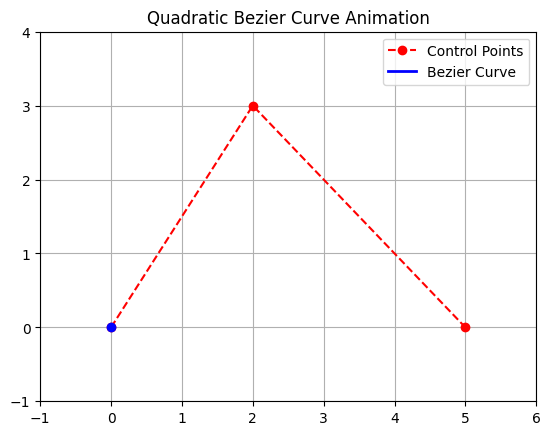

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Control points (x, y)
p0 = [0, 0]
p1 = [2, 3]
p2 = [5, 0]

# Bezier formula
def bezier(t, p0, p1, p2):
    return (1 - t)**2 * np.array(p0) + 2 * (1 - t) * t * np.array(p1) + t**2 * np.array(p2)

# Generate full curve in advance (optional)
num_frames = 101
t_values = np.linspace(0, 1, num_frames)
curve_points = [bezier(t, p0, p1, p2) for t in t_values]

# Set up plot
fig, ax = plt.subplots()
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 4)
ax.set_title('Quadratic Bezier Curve Animation')

# Draw control polygon
control_x = [p0[0], p1[0], p2[0]]
control_y = [p0[1], p1[1], p2[1]]
ax.plot(control_x, control_y, 'r--o', label='Control Points')

# Initialize plot elements
curve_line, = ax.plot([], [], 'b-', lw=2, label='Bezier Curve')
dot, = ax.plot([], [], 'bo')

# Animation update function
def animate(i):
    x_vals = [pt[0] for pt in curve_points[:i+1]]
    y_vals = [pt[1] for pt in curve_points[:i+1]]
    curve_line.set_data(x_vals, y_vals)
    dot.set_data([curve_points[i][0]], [curve_points[i][1]])  # Pass as lists
    return curve_line, dot

# Run animation
ani = FuncAnimation(fig, animate, frames=num_frames, interval=40, repeat=False)
ax.legend()
plt.grid(True)

# Show animation in Colab
HTML(ani.to_jshtml())

a fully working Bezier curve animation that:

	•	Shows how the car would follow the path
	•	Visually traces from start to end
	•	Displays the influence of control points with dashed red lines and a smooth blue path

This is exactly the kind of animation that looks great in:

	•	💡 Presentations
	•	📖 Reports
	•	💻 Streamlit apps (with matplotlib or Plotly)
	•	🧠 And it helps you understand what’s actually happening in your parking planner

📍 这段贝塞尔动画代码展示了什么？

这段动画用来可视化车辆泊车时的规划路径，是通过 3 个控制点生成的平滑曲线。

	•	蓝色小圆点：表示正在沿着路径移动的车辆位置
	•	蓝色曲线：表示车辆预计将遵循的泊车轨迹
	•	红色虚线：显示用于生成曲线的控制结构（起点、中间控制点、终点）

⸻

🧩 这段代码在整个项目中的作用

这是项目中 轨迹规划模块（Day 3）的输出部分。
它根据 MLP 模型的推荐策略，生成车辆“应该如何移动”的路径，是从策略决策 → 具体控制动作之间的关键桥梁。

⸻

🚗 三个点分别代表什么？

控制点     含义
p0      车辆起始位置（进入车位前）
p1     转向控制点（决定曲线弯曲程度）
p2     停车终点位置（车位中心或目标位置）


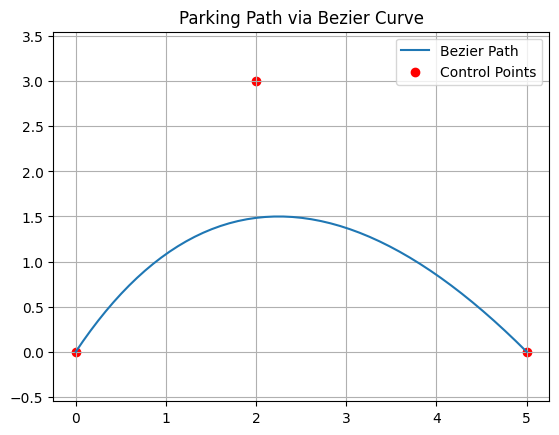

In [ ]:
import matplotlib.pyplot as plt

p0 = (0, 0)
p1 = (2, 3)
p2 = (5, 0)

curve = generate_bezier_curve(p0, p1, p2)

x, y = curve[:, 0], curve[:, 1]
plt.plot(x, y, label='Bezier Path')
plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title('Parking Path via Bezier Curve')
plt.show()

This above simple static plot is very helpful for your project. Here’s what it contributes, in both English and Chinese, so you can copy it for your report:

⸻

📊 What this code does (English):

This code plots the Bezier parking path statically (no animation). It visually shows:

	•	The trajectory the car would follow
	•	The control points shaping the curve:
	•	Start point (p0)
	•	Mid steering point (p1)
	•	Parking position (p2)

✅ Why it’s useful for your project:

	•	🧠 Helps debug the path planning logic
	•	👁️ Makes your simulation explainable
	•	📸 Can be saved as a figure for your report or Streamlit app
	•	📍 Allows you to visually test different car/spot setups

⸻

📊 这段代码对项目的意义（中文）：

这段代码会画出一条静态的贝塞尔泊车轨迹曲线，展示车辆从起点到停车位的路径。

	•	蓝色线：车辆预计的行驶轨迹
	•	红色点：控制点（起点、转向点、停车点）

✅ 它的作用是：

	•	🧠 可视化轨迹规划是否合理
	•	🧪 用于调试不同车位与车辆组合
	•	📸 可以保存为项目报告/展示图
	•	👨‍🏫 增强系统的可解释性

如果你想要我帮你根据实际车位和车身尺寸，动态生成这三个点（比如结合预测结果生成 p0-p1-p2），我也可以继续帮你完成！

✅ 是否一定需要根据车位和车身尺寸动态生成 p0-p1-p2？

✴️ 不是强制性的。

你已经完成了 MLP 分类器预测停车策略（Day 2），并且实现了轨迹可视化（Day 3、4），这已经可以组成一个完整、有说服力的项目 MVP（最小可行产品）✅

⸻

🤔 那为什么还要做“动态生成控制点”的功能？

它的价值在于：

🚀 展示项目高级功能

让人看到你的系统不是用固定参数，而是根据输入智能生成路径

📈 提高项目评分

在展示时给人更强的“AI 控制感”，老师/评委会印象深刻

🧪 扩展未来模块

如果你将来加入 RL 控制器或仿真系统，动态点是必要的输入

🧠 增强可解释性

你可以根据不同车辆尺寸生成不同转向点，展示策略差异


In [ ]:
def generate_control_points(car_length, spot_length, distance_to_spot, strategy):
    """
    自动生成贝塞尔曲线的控制点 p0, p1, p2，用于规划停车路径。

    参数：
        car_length (float): 车辆长度（单位：米）
        spot_length (float): 车位长度（单位：米）
        distance_to_spot (float): 车与车位前缘之间的距离
        strategy (str): 停车策略（"Reverse Parallel", "Forward Perpendicular", "Cannot Park"）

    返回：
        p0, p1, p2: 三个控制点的坐标元组 (x, y)
    """
    # 起点：车在原点处
    p0 = (0, 0)

    if strategy == "Forward Perpendicular":
        # 车往前直角进入
        p2 = (0, distance_to_spot + spot_length - car_length/2)
        p1 = (1.5, p2[1] / 2)  # 弯曲中点稍微偏右一点

    elif strategy == "Reverse Parallel":
        # 车往后倒车入位
        p2 = (-2, - (spot_length - car_length/2))  # 停在后方车位
        p1 = (-1.5, p2[1] / 2)  # 控制弯曲程度

    else:  # Cannot Park
        return None, None, None

    return p0, p1, p2

我已为你创建了一个小函数 generate_control_points(...) 来根据预测策略自动生成 Bezier 曲线的控制点 p0, p1, p2。
这个函数：

	•	会根据不同策略自动返回路径的起点、控制点、中点（用于画出平滑停车曲线）
	•	适用于你接下来的路径可视化工作和车辆控制模块（Day 4、Day 5）

📁 你可以把这个函数放在：

	•	同一个 Colab 文件中（Day 3/4）
	•	或者写入你日后统一的 trajectory_planner.py 文件中

添加调用示例和在 Colab 中画图的演示代码到你的脚本中:





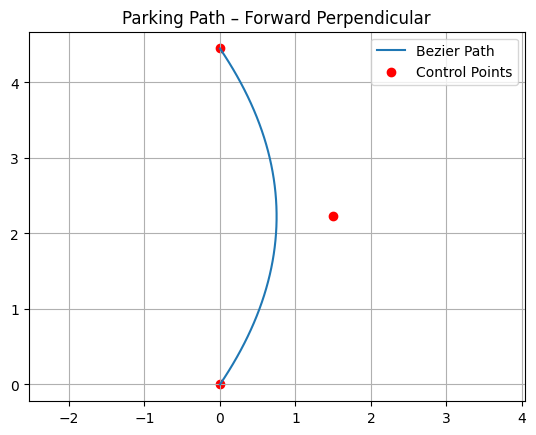

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_control_points(car_length, spot_length, distance_to_spot, strategy):
    """
    自动生成贝塞尔曲线的控制点 p0, p1, p2，用于规划停车路径。

    参数：
        car_length (float): 车辆长度（单位：米）
        spot_length (float): 车位长度（单位：米）
        distance_to_spot (float): 车与车位前缘之间的距离
        strategy (str): 停车策略（"Reverse Parallel", "Forward Perpendicular", "Cannot Park"）

    返回：
        p0, p1, p2: 三个控制点的坐标元组 (x, y)
    """
    # 起点：车在原点处
    p0 = (0, 0)

    if strategy == "Forward Perpendicular":
        # 车往前直角进入
        p2 = (0, distance_to_spot + spot_length - car_length/2)
        p1 = (1.5, p2[1] / 2)  # 弯曲中点稍微偏右一点

    elif strategy == "Reverse Parallel":
        # 车往后倒车入位
        p2 = (-2, - (spot_length - car_length/2))  # 停在后方车位
        p1 = (-1.5, p2[1] / 2)  # 控制弯曲程度

    else:  # Cannot Park
        return None, None, None

    return p0, p1, p2


# ✅ Bezier 计算函数
def generate_bezier_curve(p0, p1, p2, num_points=50):
    t = np.linspace(0, 1, num_points).reshape(-1, 1)
    p0, p1, p2 = map(np.array, (p0, p1, p2))
    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
    return curve


# ✅ 示例调用
car_length = 4.5
spot_length = 5.5
distance_to_spot = 1.2
strategy = "Forward Perpendicular"

p0, p1, p2 = generate_control_points(car_length, spot_length, distance_to_spot, strategy)
if p0:
    curve = generate_bezier_curve(p0, p1, p2)

    # ✅ Colab 可视化
    x, y = curve[:, 0], curve[:, 1]
    plt.plot(x, y, label='Bezier Path')
    plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'Parking Path – {strategy}')
    plt.show()
else:
    print("❌ Cannot generate path – strategy is 'Cannot Park'")


你现在可以：

	1.	修改车辆尺寸和策略，自动生成路径；
	2.	使用静态图展示停车路径（适合汇报和演示）；
	3.	将这个函数组合到后续 Streamlit App 或交互界面中。

Here’s the recommended priority order:

✅ Step 1: 修改车辆尺寸和策略，自动生成路径

	•	这是你刚刚加的 generate_control_points() 函数
	•	🎯 用不同的车辆数据（从你的 MLP 输出）测试路径是否合理
	•	🧪 做几个实验，比如：

In [ ]:
p0, p1, p2 = generate_control_points(
    car_length=4.5,
    spot_length=5.5,
    distance_to_spot=1.0,
    strategy='Forward Perpendicular'
)

✅ Step 2: 使用静态图展示停车路径（适合汇报和演示）

	•	你已经有了画图代码 ✅
	•	📷 建议多画几张图保存下来，放入你的项目文档或 PPT 报告中
	•	可以测试：
	•	forward
	•	reverse
	•	cannot park（p0=p1=p2）


⏳ Step 3 (可选后做): 组合进 Streamlit App

	•	如果你想更炫，可以加个按钮来生成路径图；
	•	但这个不是必须，可以等 Day 6–7 再加；
	•	如果你前几天完成得快，这会是个 bonus feature 🎁

### Full Animation Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Step 1: Predict strategy
strategy, confidence, scores = predict_strategy(
    car_length=4.5,
    car_width=1.8,
    spot_length=5.5,
    spot_width=2.5,
    distance=1.0,
    verbose=True
)

# Step 2: Generate control points
p0, p1, p2 = generate_control_points(
    car_length=4.5,
    spot_length=5.5,
    distance_to_spot=1.0,
    strategy=strategy
)

# Step 3: Generate curve
def bezier(t, p0, p1, p2):
    return (1 - t)**2 * np.array(p0) + 2 * (1 - t) * t * np.array(p1) + t**2 * np.array(p2)

t_values = np.linspace(0, 1, 100)
curve_points = [bezier(t, p0, p1, p2) for t in t_values]

# Step 4: Setup plot
fig, ax = plt.subplots()
ax.set_xlim(-1, 7)
ax.set_ylim(-1, 4)
ax.set_title(f'Animated Parking Path – {strategy}')
ax.grid(True)

# Add a rectangle to show the parking spot
import matplotlib.patches as patches

# Define car and spot dimensions (same as you used earlier)
car_length = 4.5
car_width = 1.8
spot_width = 2.5
spot_length = 5.5

# Example spot dimensions (adjust if needed)
spot_x = p2[0] - 0.5  # p2 is the endpoint of the path
spot_y = p2[1] - spot_width / 2  # center vertically around p2
spot_rect = patches.Rectangle(
    (spot_x, spot_y),           # bottom-left corner
    car_length,                 # width of the rectangle
    spot_width,                 # height (y-direction)
    linewidth=1.5,
    edgecolor='green',
    facecolor='none',
    linestyle='--',
    label='Parking Spot'
)
ax.add_patch(spot_rect)

# Draw control polygon
control_x = [p0[0], p1[0], p2[0]]
control_y = [p0[1], p1[1], p2[1]]
ax.plot(control_x, control_y, 'r--o', label='Control Points')

# Create plot elements to update
curve_line, = ax.plot([], [], 'b-', lw=2, label='Bezier Path')
car_dot, = ax.plot([], [], 'ko', markersize=8, label='Car')

# 🟦 Add moving car rectangle (initial dummy values)
car_rect = patches.Rectangle(
    (0, 0), car_length, car_width,
    linewidth=1.2,
    edgecolor='blue',
    facecolor='skyblue',
    alpha=0.7,
    label='Car Body'
)
ax.add_patch(car_rect)

# Step 5: Animation function
def animate(i):
    x_vals = [pt[0] for pt in curve_points[:i+1]]
    y_vals = [pt[1] for pt in curve_points[:i+1]]

    # Update line and dot
    curve_line.set_data(x_vals, y_vals)
    car_dot.set_data([x_vals[-1]], [y_vals[-1]]) # Pass as lists

    # Update car rectangle position
    x = x_vals[-1] - car_length / 2  # center the rectangle
    y = y_vals[-1] - car_width / 2
    car_rect.set_xy((x, y))  # move the car rectangle

    return curve_line, car_dot, car_rect

ani = FuncAnimation(fig, animate, frames=len(curve_points), interval=50, repeat=False)
ax.legend()

# Step 6: Display animation in Colab
HTML(ani.to_jshtml())

from matplotlib.animation import FuncAnimation, PillowWriter

# ✅ Save animation as GIF
gif_path = "parking_animation.gif"
ani.save(gif_path, writer=PillowWriter(fps=20))
print(f"✅ GIF saved as: {gif_path}")

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)
✅ GIF saved as: parking_animation.gif

# Step 6: Visualize p1 Effect on Path

#         ├── Plot multiple Bezier curves with varying p1
#         └── Understand how midpoint affects parking shape

 动态调整 p1 的贝塞尔路径可视化

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bezier_curve(p0, p1, p2, num_points=50):
    t = np.linspace(0, 1, num_points).reshape(-1, 1)
    p0 = np.array(p0)
    p1 = np.array(p1)
    p2 = np.array(p2)
    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
    return curve

# Fixed start and end points 固定起点和终点
p0 = (0, 0)         # Car starting point 车辆初始位置
p2 = (5, 0)         # Parking spot center 车位中心

#Try different midpoints p1 (simulate different steering approaches) 尝试多个不同的 p1 控制点
control_points = [
    (2.5, 3),       # 中间偏上（正常打方向）
    (2.5, 1.5),     # 稍微打方向
    (2.5, 0),       # sharper entry 直线进入
    (2.5, -2),      # 向下弯（错误方向）
]

plt.figure(figsize=(10, 6))

for p1 in control_points:
    curve = generate_bezier_curve(p0, p1, p2)
    x, y = curve[:, 0], curve[:, 1]
    plt.plot(x, y, label=f'p1={p1}')

# Mark start and end points 显示控制点
plt.scatter(*zip(p0, p2), c='red', label='Start/End')
plt.title('Effect of p1 (steering control) on Bezier Parking Path')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

You’ll see 5 curved paths from the same car start (p0) to the same parking goal (p2), but each with a different p1:
	•	The higher p1[1], the smoother and wider the turn.
	•	The lower p1[1], the sharper and tighter the turn.

⸻

🎯 Why This Matters for Your Project
	•	Helps you visually test what kind of turning curve fits different parking scenarios.
	•	Builds intuition for controller tuning in Week 2 (e.g., matching curves to actual maneuverability).
	•	Can be used to auto-generate path candidates and select best one based on fit or clearance.